参考：　データ分析で株価予測をしてみた　https://qiita.com/kazama0119/items/c838114f8687518ba58e


dt,endvalue
2016/1/4,1000
2016/1/5,1010
 :
 :
 :


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示

## データ読み込み

In [2]:
def read_data():
    # 日付形式で読み込む
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
    df = pd.read_csv('AirPassengers.csv', index_col='Month', date_parser=dateparse, dtype='float')
    return df

df = read_data()

## 可視化

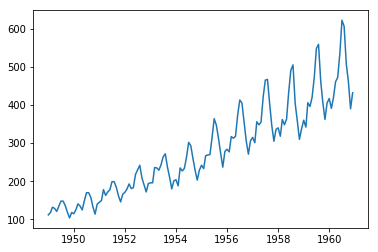

In [3]:
plt.plot(df['#Passengers'])
plt.show()

## 前処理

In [4]:
new_idx = pd.date_range(df.index[0], df.index[-1], freq='D')
df = df.reindex(new_idx, fill_value=np.nan)
df = df.interpolate()

In [5]:
df.head(10)

,#Passengers
1949-01-01,112.000000
1949-01-02,112.193548
1949-01-03,112.387097
1949-01-04,112.580645
1949-01-05,112.774194
1949-01-06,112.967742
1949-01-07,113.161290
1949-01-08,113.354839
1949-01-09,113.548387
1949-01-10,113.741935


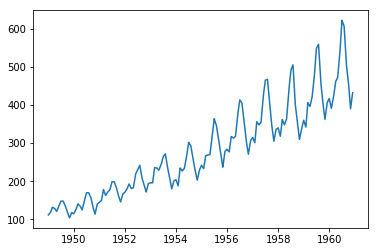

In [6]:
plt.plot(df['#Passengers'])
plt.show()

## パラメータ設定

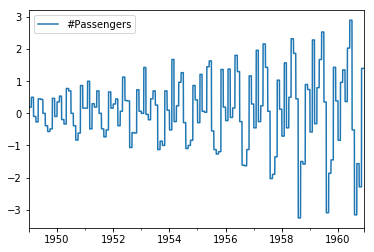

In [7]:
df_diff = df - df.shift()
df_diff = df_diff.dropna()
df_diff.plot()

In [8]:
# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(df_diff, ic='aic', trend='nc')
res_selection

{'aic':             0            1            2
 0         NaN  8472.613942  5578.327831
 1 -193.818659  -192.391913  -190.964329
 2 -192.405622          NaN  -225.994115
 3 -191.006554          NaN          NaN
 4 -189.621966  -224.001976  -225.066540,
 'aic_min_order': (2, 2)}

In [9]:
p = res_selection['aic_min_order'][0]
d = 1
q = res_selection['aic_min_order'][1]

## モデルの構築

In [10]:
SARIMA_yen_data = sm.tsa.statespace.SARIMAX(df, order=(p, d, q), seasonal_order=(0, 1, 1, 12), enforce_stationarity = False, enforce_invertibility = False).fit()
pred = SARIMA_yen_data.predict("1961-01", "1963-12", freq="D")

## 結果と予測の比較

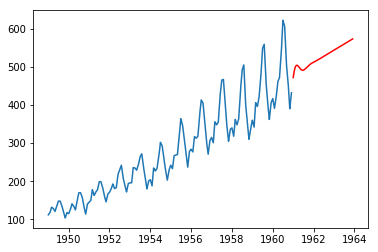

In [11]:
plt.plot(df['#Passengers'])
plt.plot(pred, c="r")
plt.show()

## パラメータ設定 ~ 結果と予測の比較  2

In [12]:
def selectparameter(df ,s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    parameters = []
    BICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.bic])
                BICs = np.append(BICs,results.bic)
            except:
                continue
    return parameters[np.argmin(BICs)]


In [13]:
# 予測
params = selectparameter(df, 12)
print(params)
order = params[0]
seasonal_order = params[1]


[(1, 1, 0), (0, 0, 0, 12), -181.05734773755594]


In [14]:
SARIMA_yen_data = sm.tsa.statespace.SARIMAX(df, order=order, seasonal_order=seasonal_order, enforce_stationarity = False, enforce_invertibility = False).fit()
pred = SARIMA_yen_data.predict("1961-01", "1963-12", freq="D")

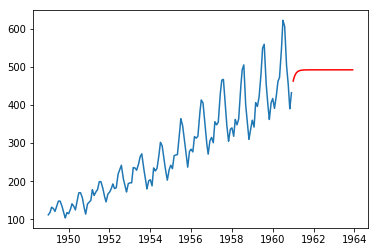

In [15]:
plt.plot(df['#Passengers'])
plt.plot(pred, c="r")
plt.show()